**Load & Explore Data**

In [44]:
# Setting up a  device agnostic code
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
# unzip it
import zipfile
with zipfile.ZipFile('train.zip','r') as zip_ref:
  zip_ref.extractall('/content/data')

KeyboardInterrupt: 

In [ ]:
import os
from collections import Counter

# Check if class folders exist
root_dir='/content/data/train'
print("classes found", os.listdir(root_dir))

# Count number of images per class
for label in os.listdir(root_dir):
  print(f"Number of images in {label}:", len(os.listdir(os.path.join(root_dir, label))))


classes found ['happy', 'sad', 'neutral', 'fear', 'disgust', 'surprise', 'angry']
Number of images in happy: 7215
Number of images in sad: 4830
Number of images in neutral: 4965
Number of images in fear: 4097
Number of images in disgust: 436
Number of images in surprise: 3171
Number of images in angry: 3995


In [12]:
# Importing dependencies

import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn

# torchvision provides tools for image loading and transformations
from torchvision import datasets, transforms

# Matplotlib to visualize image samples
import matplotlib.pyplot as plt


In [13]:
# Define training transforms with augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [14]:
# Path to the unzipped folders in your Colab
train_path = "data/train"  # Contains subfolders like angry/, happy/, etc.

# Load the training and testing datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)

# Check the emotion label names (taken from folder names)
print("Class labels:", train_dataset.classes)  # Should print: ['angry', 'disgust', 'fear', ...]


Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)   # Shuffle for better learning




---


**BUILD AND TRAIN CNN MODEL**


---



In [16]:
# Import Required Libraries
from torch import nn
import torch.nn.functional as F

In [17]:
# Defining CNN architecture
class EmotionCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features=nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),      # 48×48
        nn.BatchNorm2d(32),  # Normalises
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),      # 48×48
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),        # 24×24
        nn.Dropout(0.4),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),     # 24×24
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),       # 12×12
        nn.Dropout(0.4),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),     # 24×24
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),       # 6x6
        nn.Dropout(0.4))



    self.classifier=nn.Sequential(
        nn.Flatten(), # shape: (batch_size, 128 * 6* 6)
        nn.Linear(128*6*6,512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes) )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x



In [18]:
model=EmotionCNN(num_classes=7).to(device)
model

EmotionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

*Setting up training components*

In [ ]:
# Using CrossEntropyLoss() Good for multi-class emotion classification
loss_fn=nn.CrossEntropyLoss(label_smoothing=0.1)

# setting up optimizer
optimizer=torch.optim.Adam(params=model.parameters(), lr=3e-4)

# Creating a Accuracy function
def Accuracy(y_true, y_pred): # y_true=true labels, y_pred=model predictions
  y_pred=y_pred.argmax(dim=1)
  correct=(y_true==y_pred).sum().item()
  total=len(y_true)
  return (correct/total)*100  # converting into percentage

*Load the Dataset*


In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Split dataset 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size


# Randomly split into train + testing
train_data, test_data = random_split(train_dataset, [train_size, test_size])


*Now Create DataLoaders:*

In [20]:
# batch_size=32 → one mini-batch = 32 images
# shuffle=True for training → good for model generalization
# shuffle=False for validation → keeps order fixed

train_dataloader=DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=32, shuffle=False, )

In [21]:
for i, (images, labels) in enumerate(train_dataloader):
  print(images.shape, labels)
  if i==2:
    break

torch.Size([32, 1, 48, 48]) tensor([5, 5, 5, 6, 0, 0, 3, 4, 3, 0, 4, 4, 3, 5, 2, 5, 5, 5, 0, 3, 6, 6, 0, 3,
        2, 6, 2, 2, 3, 0, 2, 0])
torch.Size([32, 1, 48, 48]) tensor([4, 6, 5, 3, 5, 4, 3, 5, 3, 3, 5, 2, 3, 3, 6, 3, 3, 4, 3, 3, 5, 6, 6, 5,
        0, 4, 3, 2, 3, 4, 4, 5])
torch.Size([32, 1, 48, 48]) tensor([3, 5, 5, 1, 5, 0, 5, 6, 2, 5, 0, 4, 4, 4, 4, 2, 5, 6, 1, 3, 6, 3, 3, 4,
        6, 4, 5, 1, 4, 5, 6, 4])


*Building a training loop*

In [ ]:
'''model = EmotionCNN(num_classes=7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

images, labels = next(iter(train_dataloader))
images, labels = images.to(device), labels.to(device)

for i in range(100):
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    acc = (outputs.argmax(1) == labels).float().mean().item() * 100
    if i % 10 == 0:
        print(f"Step {i}: Loss = {loss.item():.4f}, Accuracy = {acc:.2f}%")'''


'model = EmotionCNN(num_classes=7).to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\nloss_fn = nn.CrossEntropyLoss()\n\nimages, labels = next(iter(train_dataloader))\nimages, labels = images.to(device), labels.to(device)\n\nfor i in range(100):\n    optimizer.zero_grad()\n    outputs = model(images)\n    loss = loss_fn(outputs, labels)\n    loss.backward()\n    optimizer.step()\n\n    acc = (outputs.argmax(1) == labels).float().mean().item() * 100\n    if i % 10 == 0:\n        print(f"Step {i}: Loss = {loss.item():.4f}, Accuracy = {acc:.2f}%")'

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
# Define the scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler=ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from tqdm import tqdm
# Set number of epochs
num_epochs =50

# Move model to device (GPU or CPU)
model = model.to(device)

for epoch in range(num_epochs):
  model.train()  # Set model to training mode
  train_loss=0
  train_acc=0

  for images, labels in tqdm(train_dataloader):
    # Move data to device
    images, labels=images.to(device), labels.to(device)

    # 1. Forward pass
    y_pred=model(images)

    # 2. calculate the Loss/accuracy
    loss=loss_fn(y_pred,labels)
    acc=Accuracy(y_true=labels, y_pred=y_pred)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # accumulating loss and accuracy
    train_loss+=loss.item()
    train_acc+=acc

  ## Testing
  model.eval()
  test_acc=0
  test_loss=0
  with torch.inference_mode():
    for images, labels in tqdm(test_dataloader):
      images, labels=images.to(device), labels.to(device)
      y_preds=model(images)
      loss=loss_fn(y_preds, labels)
      acc=Accuracy(y_true=labels, y_pred=y_preds)
      test_acc+=acc
      test_loss+=loss.item()



    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)

    test_acc/=len(test_dataloader)
    test_loss/=len(test_dataloader)
  # SCHEDULER STEP
  scheduler.step(test_acc)


  # print what's happening after 5 pochs
  if epoch % 5 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss}  | Test_acc: {test_acc:.2f}")


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.7557 | Train Acc: 32.19% | Test Loss: 1.6239614400598739  | Test_acc: 40.30


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 1.4288 | Train Acc: 51.61% | Test Loss: 1.3789206749863094  | Test_acc: 52.79


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 1.3592 | Train Acc: 55.63% | Test Loss: 1.3025964167382982  | Test_acc: 57.04


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 1.3214 | Train Acc: 57.72% | Test Loss: 1.2676814685265223  | Test_acc: 59.71


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 1.2873 | Train Acc: 59.56% | Test Loss: 1.2537669168578254  | Test_acc: 60.26


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 1.2606 | Train Acc: 61.01% | Test Loss: 1.2275597946511374  | Test_acc: 61.62


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 1.2145 | Train Acc: 63.21% | Test Loss: 1.199595280488332  | Test_acc: 63.49


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 1.1946 | Train Acc: 64.48% | Test Loss: 1.1874628487560484  | Test_acc: 63.42


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 1.1709 | Train Acc: 65.52% | Test Loss: 1.1876641015211742  | Test_acc: 63.40


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: 45 | Train Loss: 1.1634 | Train Acc: 66.55% | Test Loss: 1.178747628794776  | Test_acc: 64.54


  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/718 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
images,labels=next(iter(train_dataloader))
print("Image shape:", images.shape)

Image shape: torch.Size([32, 1, 48, 48])


***SAVE  THE  MODEL***

In [23]:
# SAVE MODEL WEIGHTS
torch.save(model.state_dict(), "emotion_model.pth")

# Evaluating on test data


In [ ]:
# unzip the test data folder
import zipfile
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
  zip_ref.extractall('data')

*Load the Test Dataset*

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Use the same transforms used for training
test_data=ImageFolder(root='data/test', transform=transform)
test_dataloader=DataLoader(test_data, batch_size=32, shuffle=False)

***Evaluate the Model on Test Data***

In [ ]:
model.eval()  # set the mpdel in evaluation mode
test_loss=0
test_acc=0

with torch.inference_mode():
  for images, labels in tqdm(test_dataloader):
    images, labels=images.to(device), labels.to(device)
    # 1. Forward pass
    y_preds=model(images)
    # 2. calculate the loss/acc
    loss=loss_fn(y_preds, labels)
    acc=Accuracy(y_true=labels, y_pred=y_preds)

    test_loss+=loss
    test_acc+=acc


  # Average over batches
  test_loss/=len(test_dataloader)
  test_acc/=len(test_dataloader)

  print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.2f}%")

  0%|          | 0/225 [00:00<?, ?it/s]

Final Test Loss: 1.1793, Final Test Accuracy: 64.44%


***Plotting the confuison matrix to check where our model is getting confused***

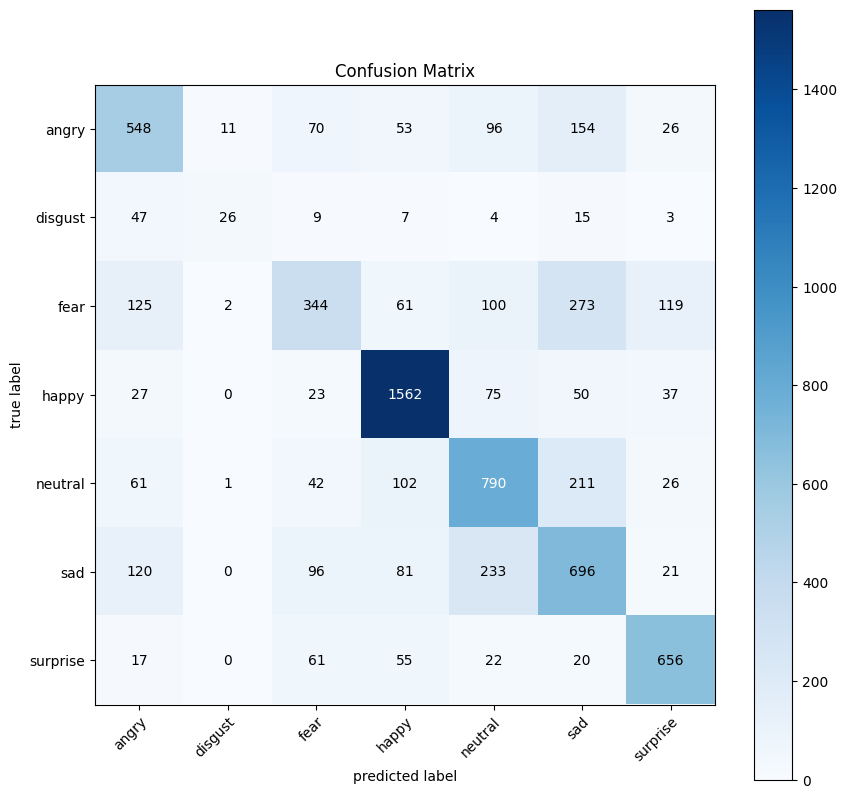

In [ ]:
# importing depenncies
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

model.eval()  # Sets the model in evaluation mode(Reduces unnecessary computation)

all_preds=[]
all_labels=[]

with torch.inference_mode():  # This disables gradient tracking
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    y_logits=model(images)
    y_preds=torch.argmax(y_logits, dim=1)
    all_preds.extend(y_preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm=confusion_matrix(all_labels, all_preds)

# Class names from dataset
class_names=train_dataset.classes

fig, axis=plot_confusion_matrix(conf_mat=cm,
                                class_names=class_names,
                                figsize=(10,10),
                                show_normed=False,
                                colorbar=True)
plt.title("Confusion Matrix")
plt.show()


# Real-time Emotion Detection via Webcam

*1: Load the Trained Model & Class Labels*

In [37]:
model=EmotionCNN(num_classes=7)
model.load_state_dict(torch.load('emotion_model.pth', map_location=torch.device(device)))
model.eval()  # Set model to evaluation mode
model.to(device)

EmotionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [27]:
# Define class labels
class_names=train_dataset.classes
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


 *Step 1: Import OpenCV and other required libraries*

In [28]:
import cv2  # for webcam and image processing
import torch
import torchvision.transforms as transforms
from PIL import Image


*Step 2: Define the same transforms used during training*

In [29]:
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # Convert webcam frame to grayscale
    transforms.Resize((48,48)),  # Resize to model's input size
    transforms.ToTensor(),   # Convert image to tensor
    transforms.Normalize((0.5),(0.5))  # Normalize to [-1, 1]

])

*Step 3: Start the webcam and make real-time prediction*s

In [42]:
from PIL import Image
import cv2
import torch

cap = cv2.VideoCapture(0)  # 0 for default webcam

# Define class names (you can use train_dataset.classes if available)
class_names = train_dataset.classes

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]  # Take first detected face
        face_roi = frame[y:y+h, x:x+w]  # Crop face region
        face_rgb = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        face_tensor = transform(face_pil).unsqueeze(0).to(device)

        # Predict emotion
        with torch.inference_mode():
            output = model(face_tensor)
            pred = output.argmax(dim=1).item()

        emotion = class_names[pred]

        # Draw bounding box and label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 255, 0),
                    thickness=2)
    else:
        # No face detected
        cv2.putText(frame, "Waiting for face...", (10, 30),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 0, 255),
                    thickness=2)

    # Show the frame
    cv2.imshow('Emotion Detector', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


In [41]:
model = EmotionCNN(num_classes=len(class_names))
p = next(model.parameters())

print("Before loading  ➜  mean | std :", p.abs().mean().item(), p.std().item())

state = torch.load("emotion_model.pth", map_location=device)
missing, unexpected = model.load_state_dict(state, strict=False)

print("After  loading  ➜  mean | std :", p.abs().mean().item(), p.std().item())
print("Missing keys :", missing)
print("Unexpected   :", unexpected)
model.eval().to(device)



Before loading  ➜  mean | std : 0.1774575114250183 0.20160289108753204
After  loading  ➜  mean | std : 0.1660793572664261 0.19340896606445312
Missing keys : []
Unexpected   : []


EmotionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

**Note on Current Model (CNN from Scratch)**

This project was originally built using a custom Convolutional Neural Network (CNN) from scratch, as part of my hands-on learning in PyTorch and deep learning fundamentals.

The model reaches a maximum validation accuracy of ~65% and consistently over-predicts a single class ("surprise") — which suggests issues like class imbalance, model capacity limitations, or overfitting.

While this implementation helped me deeply understand CNN architecture design, image preprocessing, and the challenges of emotion classification, I’ve identified the need for stronger feature extractors and better generalization.

Therefore, I’m transitioning this project to use Transfer Learning (with ResNet18), which I’ve started exploring in the next version of this project.